In [ ]:
import kagglehub
gpiosenka_cards_image_datasetclassification_path = kagglehub.dataset_download('gpiosenka/cards-image-datasetclassification')

print('Data source import complete.')


Data source import complete.


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

from torchvision import datasets, transforms, models
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
from torchvision.utils import make_grid

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

from sklearn.metrics import confusion_matrix, classification_report, f1_score
from tqdm import tqdm

In [ ]:
train_dir = '/kaggle/input/cards-image-datasetclassification/train'
val_dir = '/kaggle/input/cards-image-datasetclassification/valid'
test_dir = '/kaggle/input/cards-image-datasetclassification/test'

In [ ]:
transform = transforms.Compose([
    transforms.Resize((150, 150)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [ ]:
train_dataset = datasets.ImageFolder(train_dir, transform=transform)
val_dataset = datasets.ImageFolder(val_dir, transform=transform)
test_dataset = datasets.ImageFolder(test_dir, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32)
test_loader = DataLoader(test_dataset, batch_size=32)

In [ ]:
def imshow(images,labels,class_names):
    images = images.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    images = std * images + mean
    images = np.clip(images, 0, 1)
    plt.imshow(images)
    plt.title(", ".join([class_names[l] for l in labels]))
    plt.show()

In [ ]:
class_names = train_loader.dataset.classes
class_names

['ace of clubs',
 'ace of diamonds',
 'ace of hearts',
 'ace of spades',
 'eight of clubs',
 'eight of diamonds',
 'eight of hearts',
 'eight of spades',
 'five of clubs',
 'five of diamonds',
 'five of hearts',
 'five of spades',
 'four of clubs',
 'four of diamonds',
 'four of hearts',
 'four of spades',
 'jack of clubs',
 'jack of diamonds',
 'jack of hearts',
 'jack of spades',
 'joker',
 'king of clubs',
 'king of diamonds',
 'king of hearts',
 'king of spades',
 'nine of clubs',
 'nine of diamonds',
 'nine of hearts',
 'nine of spades',
 'queen of clubs',
 'queen of diamonds',
 'queen of hearts',
 'queen of spades',
 'seven of clubs',
 'seven of diamonds',
 'seven of hearts',
 'seven of spades',
 'six of clubs',
 'six of diamonds',
 'six of hearts',
 'six of spades',
 'ten of clubs',
 'ten of diamonds',
 'ten of hearts',
 'ten of spades',
 'three of clubs',
 'three of diamonds',
 'three of hearts',
 'three of spades',
 'two of clubs',
 'two of diamonds',
 'two of hearts',
 'two o

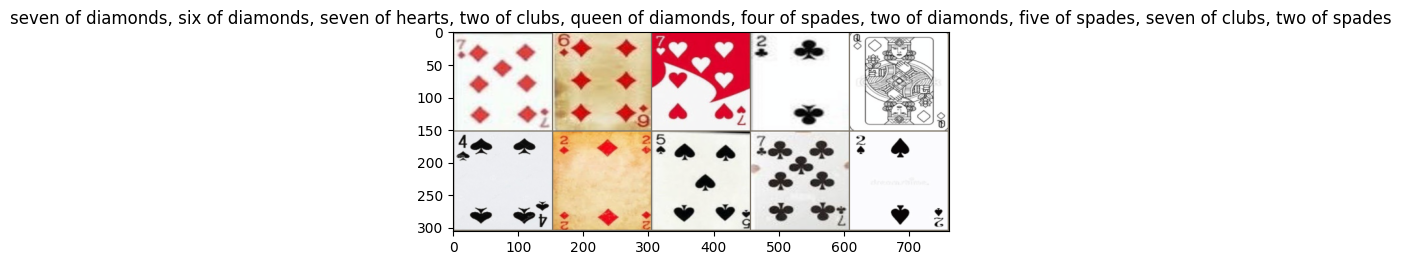

In [ ]:
dataiter = iter(train_loader)
images, labels = next(dataiter)

imshow(make_grid(images[:10], nrow=5), labels[:10], class_names)

In [ ]:
print(f"Кількість класів: {len(train_dataset.classes)}")
print(f"Класи: {train_dataset.classes}")
print(f"Розмір тренувального набору: {len(train_dataset)}")
print(f"Розмір валідаційного набору: {len(val_dataset)}")
print(f"Розмір тестового набору: {len(test_dataset)}")

class_counts = {class_name: 0 for class_name in train_dataset.classes}
for _, label in train_dataset.samples:
    class_counts[train_dataset.classes[label]] += 1

print("\nРозподіл класів у тренувальному наборі:")
for class_name, count in class_counts.items():
    print(f"{class_name}: {count}")

Кількість класів: 53
Класи: ['ace of clubs', 'ace of diamonds', 'ace of hearts', 'ace of spades', 'eight of clubs', 'eight of diamonds', 'eight of hearts', 'eight of spades', 'five of clubs', 'five of diamonds', 'five of hearts', 'five of spades', 'four of clubs', 'four of diamonds', 'four of hearts', 'four of spades', 'jack of clubs', 'jack of diamonds', 'jack of hearts', 'jack of spades', 'joker', 'king of clubs', 'king of diamonds', 'king of hearts', 'king of spades', 'nine of clubs', 'nine of diamonds', 'nine of hearts', 'nine of spades', 'queen of clubs', 'queen of diamonds', 'queen of hearts', 'queen of spades', 'seven of clubs', 'seven of diamonds', 'seven of hearts', 'seven of spades', 'six of clubs', 'six of diamonds', 'six of hearts', 'six of spades', 'ten of clubs', 'ten of diamonds', 'ten of hearts', 'ten of spades', 'three of clubs', 'three of diamonds', 'three of hearts', 'three of spades', 'two of clubs', 'two of diamonds', 'two of hearts', 'two of spades']
Розмір тренув

In [ ]:
class SimpleCNN(nn.Module):
    def __init__(self, num_classes=36):
        super(SimpleCNN, self).__init__()

        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)

        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(64)

        self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(128)

        self._initialize_fc_layer()

        self.fc1 = nn.Linear(self.fc1_in_features, 512)
        self.fc2 = nn.Linear(512, num_classes)

    def _initialize_fc_layer(self):
        with torch.no_grad():
            dummy_input = torch.zeros(1, 3, 150, 150)
            dummy_output = self._forward_conv_layers(dummy_input)
            self.fc1_in_features = dummy_output.numel()

    def _forward_conv_layers(self, x):
        x = self.pool(F.relu(self.bn1(self.conv1(x))))
        x = self.pool(F.relu(self.bn2(self.conv2(x))))
        x = self.pool(F.relu(self.bn3(self.conv3(x))))
        return x

    def forward(self, x):
        x = self._forward_conv_layers(x)
        x = x.view(-1, self.fc1_in_features)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [ ]:
model = SimpleCNN(num_classes=53)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = model.to(device)

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

num_epochs = 10
best_val_loss = float('inf')
train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []

In [ ]:
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for inputs, labels in tqdm(train_loader):
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    train_loss = running_loss / len(train_loader)
    train_accuracy = correct / total
    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)

    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                val_loss += loss.item()

                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

    val_loss /= len(val_loader)
    val_accuracy = correct / total
    val_losses.append(val_loss)
    val_accuracies.append(val_accuracy)

    print(f'Epoch {epoch+1}/{num_epochs}:')
    print(f'Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}')
    print(f'Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.4f}')

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model.state_dict(), 'best_model_1.pth')

 15%|█▌        | 36/239 [01:38<09:14,  2.73s/it]


KeyboardInterrupt: 

In [ ]:
def visualize_predictions(model, dataloader, class_names, num_images=5):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure(figsize=(15, 10))

    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size(0)):
                if images_so_far == num_images:
                    model.train(mode=was_training)
                    plt.tight_layout()
                    plt.show()
                    return

                images_so_far += 1
                ax = plt.subplot(num_images//2 + 1, 2, images_so_far)
                ax.axis('off')
                ax.set_title(f'Predicted: {class_names[preds[j]]}\nTrue: {class_names[labels[j]]}')

                inv_normalize = transforms.Normalize(
                    mean=[-0.485/0.229, -0.456/0.224, -0.406/0.225],
                    std=[1/0.229, 1/0.224, 1/0.225]
                )
                inp = inv_normalize(inputs.cpu()[j]).numpy().transpose((1, 2, 0))
                inp = np.clip(inp, 0, 1)

                plt.imshow(inp)

    model.train(mode=was_training)
    plt.tight_layout()
    plt.show()

In [ ]:
def plot_training_metrics(train_losses, train_accuracies, val_losses, val_accuracies):
    epochs = range(1, len(train_losses) + 1)

    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_losses, 'b-', label='Training Loss')
    plt.plot(epochs, val_losses, 'r-', label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_accuracies, 'b-', label='Training Accuracy')
    plt.plot(epochs, val_accuracies, 'r-', label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.show()

In [ ]:
model.load_state_dict(torch.load('best_model_1.pth'))
model.eval()

correct = 0
total = 0
all_preds = []
all_labels = []

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

Test Accuracy: 0.7736
F1 Score: 0.7710


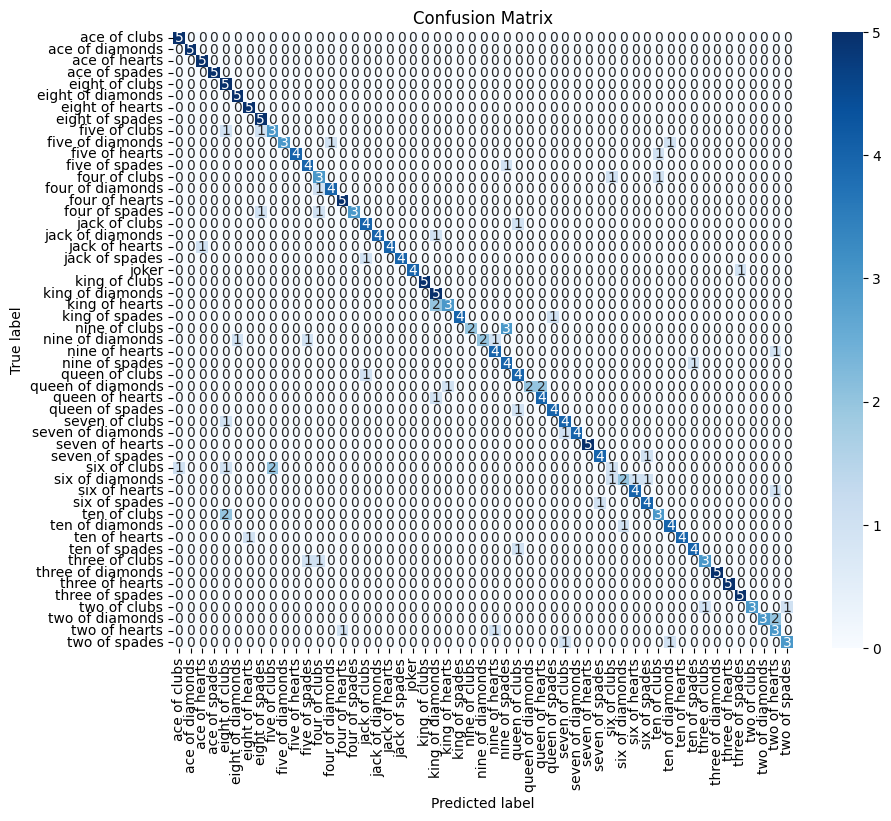

In [ ]:
class_names = train_dataset.classes

test_accuracy = correct / total
f1 = f1_score(all_labels, all_preds, average='weighted')

print(f'Test Accuracy: {test_accuracy:.4f}')
print(f'F1 Score: {f1:.4f}')

cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(10,8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix')
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

In [ ]:
min_len = min(len(train_losses), len(train_accuracies), len(val_losses), len(val_accuracies))
train_losses = train_losses[:min_len]
train_accuracies = train_accuracies[:min_len]
val_losses = val_losses[:min_len]
val_accuracies = val_accuracies[:min_len]

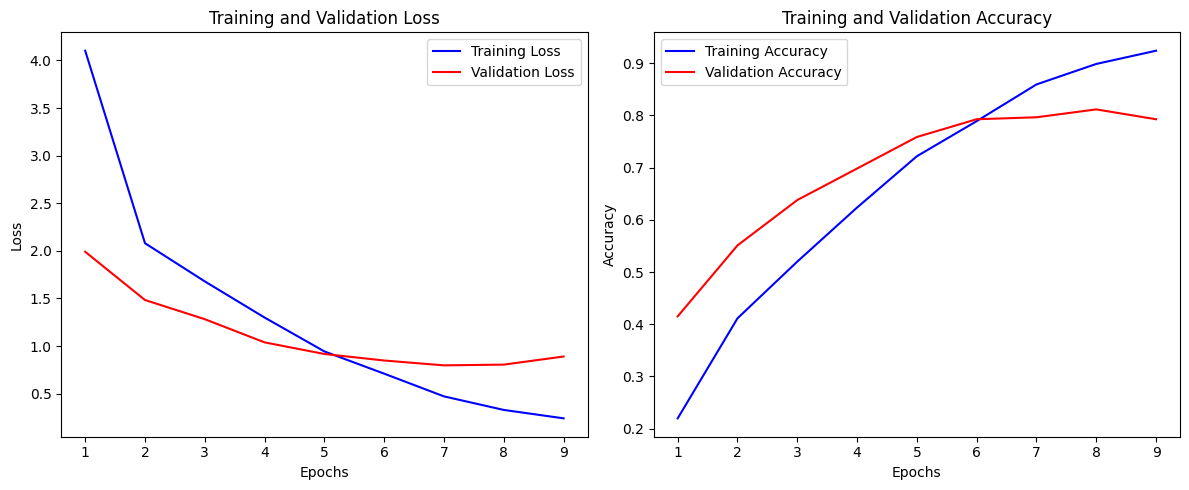

In [ ]:
plot_training_metrics(train_losses, train_accuracies, val_losses, val_accuracies)

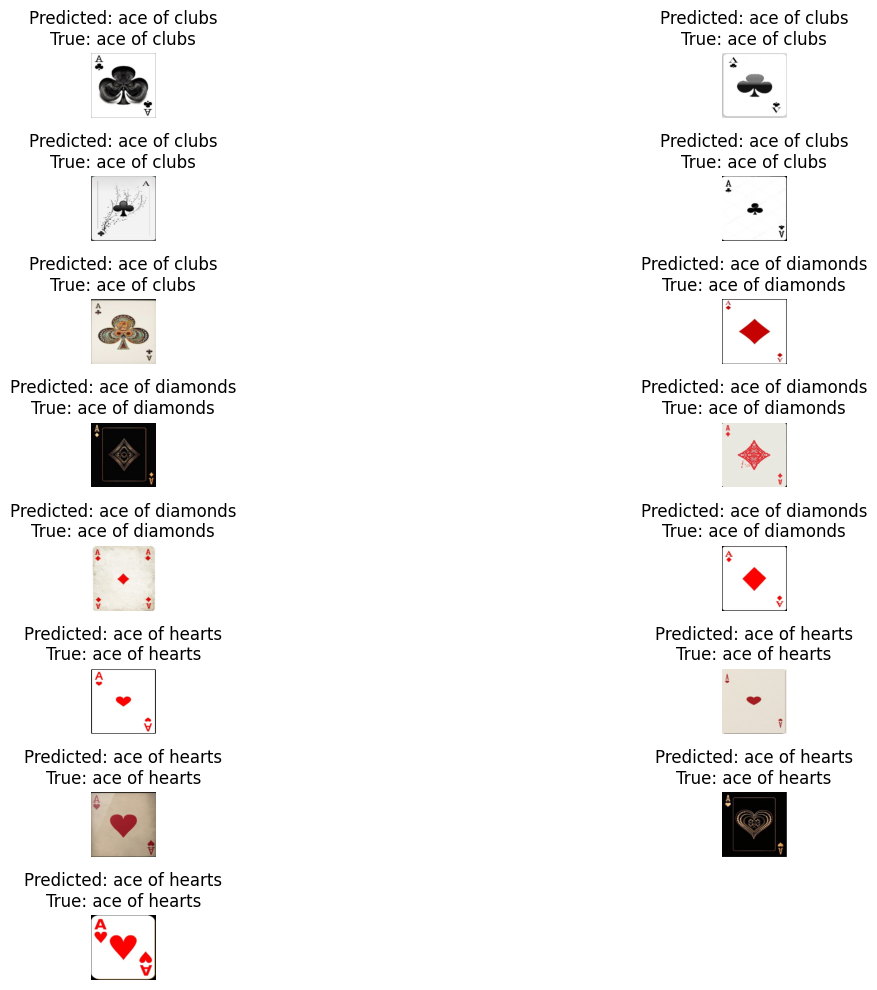

In [ ]:
visualize_predictions(model, test_loader, train_dataset.classes, 15)

In [ ]:
from torchvision import models
import torch.nn as nn

In [ ]:
vgg16 = models.vgg16(pretrained=True)

for param in vgg16.features.parameters():
    param.requires_grad = False

num_classes = len(train_dataset.classes)

vgg16.classifier[6] = nn.Linear(4096, num_classes)

vgg16 = vgg16.to(device)

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:06<00:00, 91.5MB/s]


In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(vgg16.classifier[6].parameters(), lr=0.0001)

In [ ]:
train_losses_vgg, val_losses_vgg = [], []
train_accuracies_vgg, val_accuracies_vgg = [], []

num_epochs = 10
for epoch in range(num_epochs):
    vgg16.train()
    train_loss = 0.0
    correct = 0
    total = 0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = vgg16(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    avg_train_loss = train_loss / len(train_loader)
    train_acc = correct / total
    train_losses_vgg.append(avg_train_loss)
    train_accuracies_vgg.append(train_acc)

    vgg16.eval()
    val_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = vgg16(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    avg_val_loss = val_loss / len(test_loader)
    val_acc = correct / total
    val_losses_vgg.append(avg_val_loss)
    val_accuracies_vgg.append(val_acc)

    print(f"Epoch {epoch+1}/{num_epochs} | Train Loss: {avg_train_loss:.4f}, Acc: {train_acc:.4f} | Val Loss: {avg_val_loss:.4f}, Acc: {val_acc:.4f}")

In [ ]:
vgg16.eval()
correct = 0
total = 0
all_preds = []
all_labels = []

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = vgg16(inputs)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

vgg16_acc = correct / total
vgg16_f1 = f1_score(all_labels, all_preds, average='weighted')
print(f"VGG16 Test Accuracy: {vgg16_acc:.4f}")
print(f"VGG16 F1 Score: {vgg16_f1:.4f}")

In [ ]:
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(10,8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=train_dataset.classes,
            yticklabels=train_dataset.classes)
plt.title('Confusion Matrix for VGG16')
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

In [ ]:
plot_training_metrics(train_losses_vgg, train_accuracies_vgg, val_losses_vgg, val_accuracies_vgg)

### **Висновки**

У межах даної лабораторної роботи було реалізовано дві моделі для класифікації зображень: власну модель CNN та претреновану модель VGG16. Обидві моделі були навчені й протестовані на одному й тому самому наборі даних для порівняння їхньої ефективності.

Модель CNN продемонструвала гідні результати, однак її точність виявилася нижчою, ніж у VGG16. Це очікувано, адже VGG16 — це глибока нейронна мережа, попередньо навчена на великому обсязі зображень. Завдяки цьому вона досягла вищої точності при значно меншому обсязі донавчання.

Використання VGG16 дозволило не лише покращити результати, але й зменшити час навчання, обійшовшись без побудови складної архітектури з нуля.

Матриця плутанини та графіки втрат і точності допомогли краще оцінити поведінку моделей у процесі навчання та тестування. Це дозволило проаналізувати сильні й слабкі сторони обох підходів і зробити обґрунтований вибір моделі для подальшого застосування.

Загалом, лабораторна робота підкреслила важливість використання претренованих моделей у задачах комп’ютерного зору, особливо у випадках обмеженого обсягу навчальних даних. Також було підтверджено, що візуалізація результатів є важливим інструментом для аналізу та кращого розуміння роботи нейронних мереж.